В файле <i>orders</i> представлена информация о заказах в онлайн-магазине.
```
OrderID - ID Заказа,
UserID - ID клиента,
OrderTime - время заказа,
items - список элементов в заказе, каждый элемент описан словарем:
    ItemID  - ID продукта, 
    price - цена единицы товара, 
    quantity - количество единиц товара в заказе
```
В файле <i>categories</i> представлена информация о категории товаров.
```
ItemID - ID продукта,
Category - категория продукта,
ParentCategory - более крупная категория продукта

## Анализ логов продуктового магазина

Представьте, что вы работаете аналитиком онлайн-магазина и ваша цель - повысить GMV (суммарную выручку от продажи товаров). Для этого вы хотите провести ряд исследований и придумать какие-то меры для увеличения выручки.

* Визуализируйте динамику продаж напитков в ParentCategory. Есть ли эффект сезонности в продажах?
* Исследуйте и покажите на графике, как отличаются продажи в будние и выходные в категориях 'Сокосодержащие напитки, смузи' и "Печенье"  ?
* Визуализируйте структуру продаж ParentCategory по показателю GMV за один месяц. Укажите категорию с наибольшей долей GMV.
* Исследуйте взаимосвясь между продажами категорий 'Чипсы, снеки, попкорн' и напитками:'Вода', 'Газированные напитки',  'Соки, нектары', 'Лимонады', 'Безалкогольное пиво', 'Вино', 'Пиво'. С чем сильнее коррелируют 'Чипсы, снеки, попкорн'?

In [23]:
pip install matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\Agito\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [1]:
# Установка библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [25]:
# Чтение файлов
categories = pd.read_csv('data/categories.csv')
orders = pd.read_json('data/orders.json')

* Визуализируйте динамику продаж напитков в ParentCategory. Есть ли эффект сезонности в продажах?

In [26]:
# Слияние данных о заказах
orders_expanded = orders.explode('items')
items_df = pd.json_normalize(orders_expanded['items'])
orders_expanded = orders_expanded.drop(columns=['items']).join(items_df)

In [27]:
# Приведение типов данных к строковому формату для 'ItemID'
orders_expanded['ItemID'] = orders_expanded['ItemID'].astype(str)
categories['ItemID'] = categories['ItemID'].astype(str)

In [28]:
# Объединяю с данными о категориях
merged_data = orders_expanded.merge(categories, on='ItemID', how='left')

In [29]:
# Фильтрую данные по категории "Напитки" в ParentCategory
beverages = merged_data[merged_data['ParentCategory'] == 'Напитки']

In [30]:
# Преобразую время заказа в формат datetime
beverages['OrderTime'] = pd.to_datetime(beverages['OrderTime'])

C:\Users\Agito\AppData\Local\Temp\ipykernel_4428\3284007746.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beverages['OrderTime'] = pd.to_datetime(beverages['OrderTime'])


In [31]:
# Вычисляю GMV
beverages['GMV'] = beverages['price'] * beverages['quantity']

C:\Users\Agito\AppData\Local\Temp\ipykernel_4428\760346340.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beverages['GMV'] = beverages['price'] * beverages['quantity']


In [32]:
# Вычисляю колличество пропусков в GMV
print(beverages['GMV'].isnull().sum())

0


In [33]:
# Удаляю строки с пропусками в GMV
beverages = beverages.dropna(subset=['GMV'])

In [34]:
# Группирую по месяцам и суммирую GMV
beverages['month'] = beverages['OrderTime'].dt.to_period('M')
monthly_sales = beverages.groupby('month')['GMV'].sum().reset_index()

In [35]:
# Приведение типа 'month' к строковому формату для правильной визуализации
monthly_sales['month'] = monthly_sales['month'].astype(str)

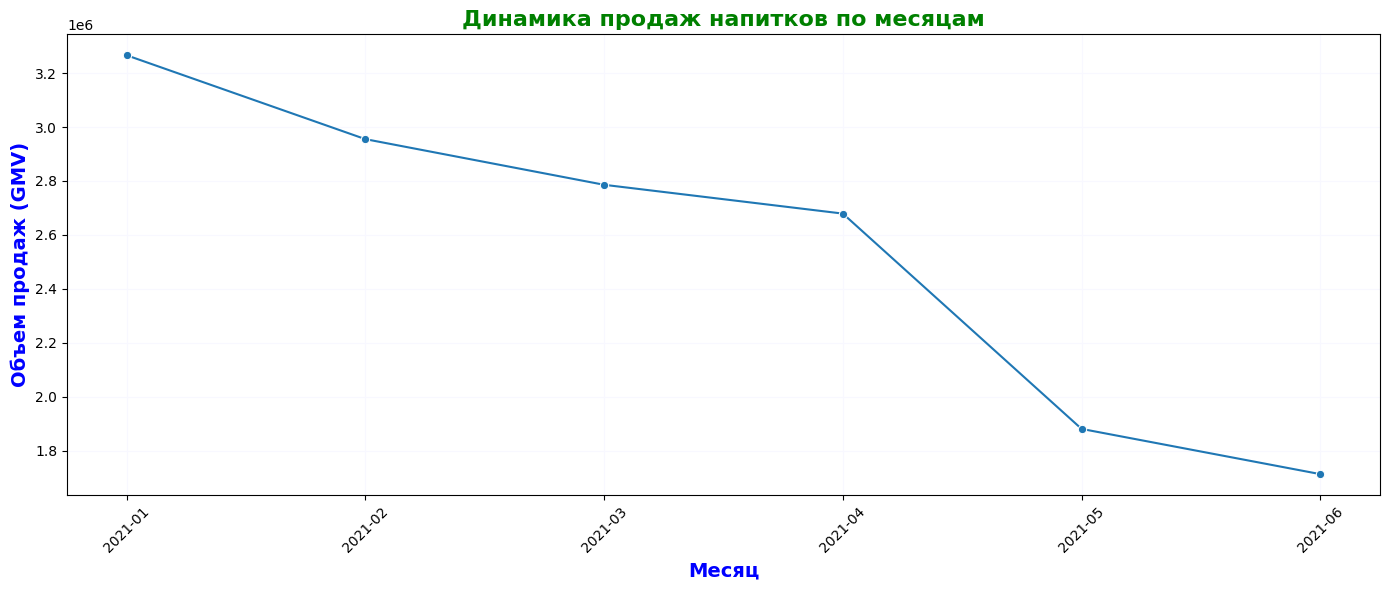

In [36]:
# Визуализация
plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_sales, x='month', y='GMV', marker='o')
plt.title('Динамика продаж напитков по месяцам', fontsize=16, fontweight='bold', color='Green')
plt.xlabel('Месяц', fontsize=14, fontweight='bold', color='Blue')
plt.ylabel('Объем продаж (GMV)', fontsize=14, fontweight='bold', color='Blue')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.grid(color='ghostwhite')
plt.show()

* Исследуйте и покажите на графике, как отличаются продажи в будние и выходные в категориях 'Сокосодержащие напитки, смузи' и "Печенье"  ?

In [37]:
print(categories['Category'].unique())

['Сладости для диабетиков' 'Вода' 'Фрукты' 'Мыло' 'Товары для праздника'
 'Конфеты' 'Кастрюли' 'Чипсы, снеки, попкорн' 'Крупы и бобовые'
 'Специи и приправы' 'Сыры' 'Шоколадные плитки' 'Шоколад, батончики'
 'Кофе' 'Овощные консервы' 'Овощи' 'Готовые блюда охлажденные' 'Яйцо'
 'Соки, нектары' 'Пресервы и рыбные закуски' 'Пирожные' 'Сушки, сухари'
 'Кухонные инструменты' 'Уход за лицом' 'Восточные сладости, халва'
 'Лакомства для животных' 'Белый хлеб' 'Формы для выпечки'
 'Хлеб, лаваш, лепешки' 'Булочки' 'Косметика' 'Гирлянды'
 'Продукты быстрого приготовления' 'Подушечки, мюсли, хлопья' 'Чай'
 'Средства для губ' 'Батарейки' 'Елочные украшения' 'Веники, совки, щетки'
 'Щетки для стекла' 'Торты' 'Рыбные консервы' 'Шампуни' 'Круассаны'
 'Косметика для глаз' 'Аэрозоли' 'Борьба с насекомыми' 'Уход за обувью'
 'Галантерейные аксессуары' 'Для ванны и туалета' 'Творог, сырки'
 'Сладости' 'Гели для душа' 'Фруктовые и ягодные консервы ' 'Пюре'
 'Лимонады' 'Сокосодержащие напитки, смузи' 'Устройс

In [41]:
# Преобразование данных о заказах
orders_expanded = orders.explode('items')
items_df = pd.json_normalize(orders_expanded['items'])
orders_expanded = orders_expanded.drop(columns=['items']).join(items_df)

In [42]:
# Приведение типов данных к строковому формату для 'ItemID'
orders_expanded['ItemID'] = orders_expanded['ItemID'].astype(str)
categories['ItemID'] = categories['ItemID'].astype(str)

In [43]:
# Объединяю с данными о категориях
merged_data = orders_expanded.merge(categories, on='ItemID', how='left')

In [44]:
# Преобразую время заказа в формат datetime
merged_data['OrderTime'] = pd.to_datetime(merged_data['OrderTime'])

In [45]:
# Добавляю столбец с днем недели
merged_data['Weekday'] = merged_data['OrderTime'].dt.day_name()

In [46]:
# Определяю выходные дни
merged_data['IsWeekend'] = merged_data['Weekday'].isin(['Saturday', 'Sunday'])

In [47]:
# Фильтрую данные по интересующим категориям
filtered_data = merged_data[merged_data['Category'].str.strip().isin(['Сокосодержащие напитки, смузи', 'Печенье'])]

In [48]:
# Группирую данные по категориям и выходным/будним дням
sales_summary = filtered_data.groupby(['Category', 'IsWeekend'])['quantity'].sum().reset_index()

In [49]:
# Переименую столбец для удобства
sales_summary['DayType'] = sales_summary['IsWeekend'].map({True: 'Выходные', False: 'Будние'})

In [50]:
# Проверка данных перед визуализацией
print(sales_summary)

                        Category  IsWeekend  quantity   DayType
0                        Печенье      False     14825    Будние
1                        Печенье       True      5227  Выходные
2  Сокосодержащие напитки, смузи      False      1054    Будние
3  Сокосодержащие напитки, смузи       True      1038  Выходные


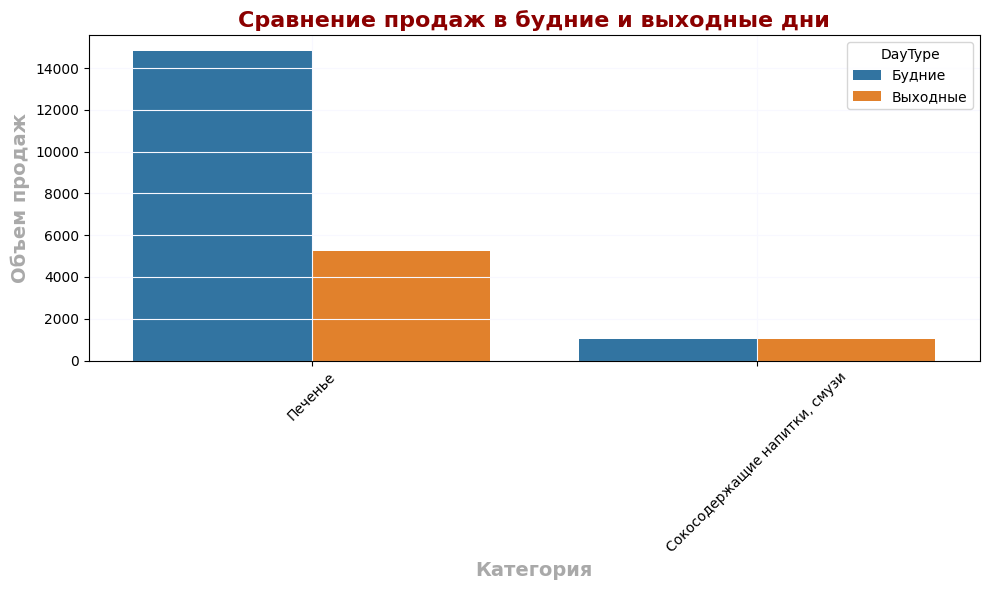

In [54]:
# Визуализация
if not sales_summary.empty:
    plt.figure(figsize=(10, 6))
    barplot = sns.barplot(data=sales_summary, x='Category', y='quantity', hue='DayType', dodge=True)

    # Добавление заголовка и подписей
    plt.title('Сравнение продаж в будние и выходные дни', fontsize=16, fontweight='bold', color='DarkRed')
    plt.xlabel('Категория', fontsize=14, fontweight='bold', color='DarkGray')
    plt.ylabel('Объем продаж', fontsize=14, fontweight='bold', color='DarkGray')
    plt.xticks(rotation=45)
    plt.grid(color='ghostwhite')

    plt.tight_layout()
    plt.show()


In [14]:
# Проверка на наличие данных после фильтрации
print("Отфильтрованные данные:", filtered_data)

Отфильтрованные данные: Empty DataFrame
Columns: [OrderID, UserID, OrderTime, Date, ItemID, price, quantity, Category, ParentCategory, Weekday, IsWeekend]
Index: []


In [16]:
print(categories['Category'].unique())

['Сладости для диабетиков' 'Вода' 'Фрукты' 'Мыло' 'Товары для праздника'
 'Конфеты' 'Кастрюли' 'Чипсы, снеки, попкорн' 'Крупы и бобовые'
 'Специи и приправы' 'Сыры' 'Шоколадные плитки' 'Шоколад, батончики'
 'Кофе' 'Овощные консервы' 'Овощи' 'Готовые блюда охлажденные' 'Яйцо'
 'Соки, нектары' 'Пресервы и рыбные закуски' 'Пирожные' 'Сушки, сухари'
 'Кухонные инструменты' 'Уход за лицом' 'Восточные сладости, халва'
 'Лакомства для животных' 'Белый хлеб' 'Формы для выпечки'
 'Хлеб, лаваш, лепешки' 'Булочки' 'Косметика' 'Гирлянды'
 'Продукты быстрого приготовления' 'Подушечки, мюсли, хлопья' 'Чай'
 'Средства для губ' 'Батарейки' 'Елочные украшения' 'Веники, совки, щетки'
 'Щетки для стекла' 'Торты' 'Рыбные консервы' 'Шампуни' 'Круассаны'
 'Косметика для глаз' 'Аэрозоли' 'Борьба с насекомыми' 'Уход за обувью'
 'Галантерейные аксессуары' 'Для ванны и туалета' 'Творог, сырки'
 'Сладости' 'Гели для душа' 'Фруктовые и ягодные консервы ' 'Пюре'
 'Лимонады' 'Сокосодержащие напитки, смузи' 'Устройс

Визуализируйте структуру продаж ParentCategory по показателю GMV за один месяц. Укажите категорию с наибольшей долей GMV.

In [22]:
# Чтение файлов
categories = pd.read_csv('data/categories.csv')
orders = pd.read_json('data/orders.json')

In [23]:
# Преобразую данные о заказах
orders_expanded = orders.explode('items')
items_df = pd.json_normalize(orders_expanded['items'])
orders_expanded = orders_expanded.drop(columns=['items']).join(items_df)

In [24]:
# Приведение типов данных к строковому формату для 'ItemID'
orders_expanded['ItemID'] = orders_expanded['ItemID'].astype(str)
categories['ItemID'] = categories['ItemID'].astype(str)

In [25]:
# Объединяю с данными о категориях
merged_data = orders_expanded.merge(categories, on='ItemID', how='left')

In [26]:
# Преобразование времени заказа в формат datetime
merged_data['OrderTime'] = pd.to_datetime(merged_data['OrderTime'])

In [27]:
# Фильтрую данные за один месяц
start_date = '2021-06-01'
end_date = '2021-06-30'
filtered_data = merged_data[(merged_data['OrderTime'] >= start_date) & (merged_data['OrderTime'] <= end_date)]

In [28]:
# Проверяю на наличие данных после фильтрации
if filtered_data.empty:
    print("Нет данных за указанный период.")
else:
    # Расчет GMV для каждой категории
    filtered_data['GMV'] = filtered_data['price'] * filtered_data['quantity']
    gvm_summary = filtered_data.groupby('ParentCategory')['GMV'].sum().reset_index()

    # Определение категории с наибольшей долей GMV
    total_gmv = gvm_summary['GMV'].sum()
    gvm_summary['Percentage'] = (gvm_summary['GMV'] / total_gmv) * 100

    # Проверяю на наличие данных в gvm_summary
    if gvm_summary.empty:
        print("Нет данных для расчета GMV по категориям.")
    else:
        max_gmv_category = gvm_summary.loc[gvm_summary['GMV'].idxmax()]

C:\Users\Agito\AppData\Local\Temp\ipykernel_15520\3242854563.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['GMV'] = filtered_data['price'] * filtered_data['quantity']


C:\Users\Agito\AppData\Local\Temp\ipykernel_15520\516750465.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=gvm_summary, x='ParentCategory', y='GMV', palette='viridis')


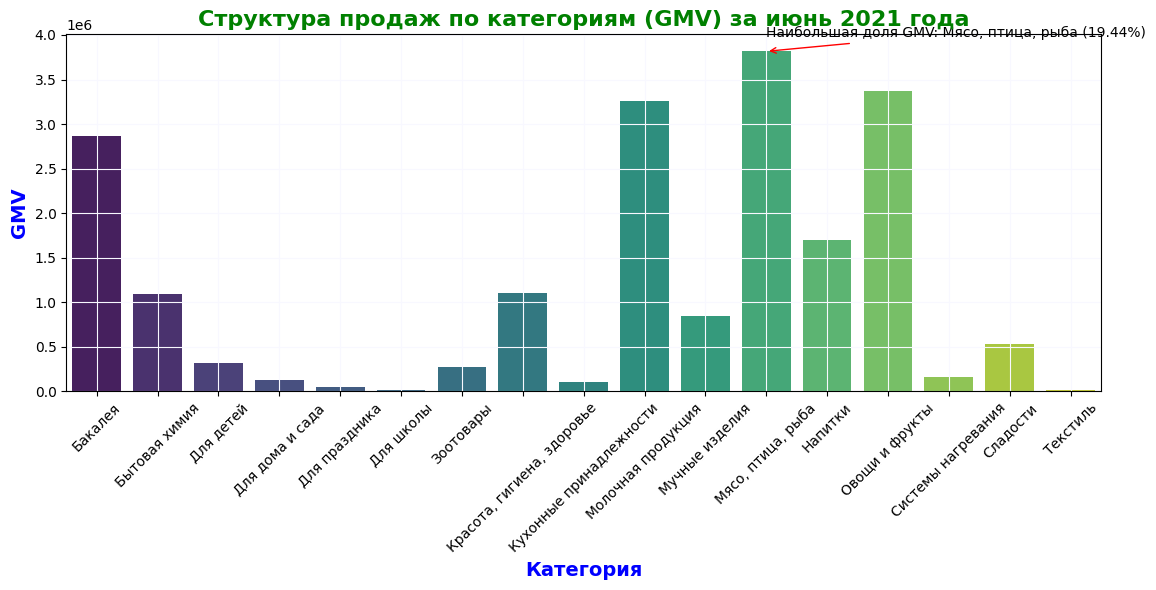

In [29]:
        # Визуализация
        plt.figure(figsize=(12, 6))
        sns.barplot(data=gvm_summary, x='ParentCategory', y='GMV', palette='viridis')
        plt.title('Структура продаж по категориям (GMV) за июнь 2021 года', fontsize=16, fontweight='bold', color='Green')
        plt.xlabel('Категория', fontsize=14, fontweight='bold', color='Blue')
        plt.ylabel('GMV', fontsize=14, fontweight='bold', color='Blue')
        plt.xticks(rotation=45)
        plt.grid(color='ghostwhite')

        # Добавление информации о категории с наибольшей долей GMV
        plt.annotate(f'Наибольшая доля GMV: {max_gmv_category["ParentCategory"]} ({max_gmv_category["Percentage"]:.2f}%)',
                     xy=(gvm_summary['ParentCategory'].tolist().index(max_gmv_category['ParentCategory']), max_gmv_category['GMV']),
                     xytext=(0, 10), textcoords='offset points', arrowprops=dict(arrowstyle='->', color='red'))

        plt.tight_layout()
        plt.show()

Исследуйте взаимосвязь между продажами категорий 'Чипсы, снеки, попкорн' и напитками:'Вода', 'Газированные напитки',  'Соки, нектары', 'Лимонады', 'Безалкогольное пиво', 'Вино', 'Пиво'. С чем сильнее коррелируют 'Чипсы, снеки, попкорн'?

In [6]:
# Чтение файлов
categories = pd.read_csv('data/categories.csv')
orders = pd.read_json('data/orders.json')

In [7]:
# Преобразую данные о заказах
orders_expanded = orders.explode('items')
items_df = pd.json_normalize(orders_expanded['items'])
orders_expanded = orders_expanded.drop(columns=['items']).join(items_df)

In [8]:
# Приведение типов данных к строковому формату для 'ItemID'
orders_expanded['ItemID'] = orders_expanded['ItemID'].astype(str)
categories['ItemID'] = categories['ItemID'].astype(str)

In [9]:
# Объединяю с данными о категориях
merged_data = orders_expanded.merge(categories, on='ItemID', how='left')

In [10]:
# Приведение 'OrderTime' к формату datetime
merged_data['OrderTime'] = pd.to_datetime(merged_data['OrderTime'], errors='coerce')

In [11]:
# Проверяю на наличие пустых значений в 'OrderTime'
if merged_data['OrderTime'].isnull().any():
    print("Обнаружены некорректные даты в 'OrderTime'.")

In [12]:
# Расчет GMV
merged_data['GMV'] = merged_data['price'] * merged_data['quantity']

In [13]:
# Фильтрую данные по категориям
snacks_data = merged_data[merged_data['Category'] == 'Чипсы, снеки, попкорн']
drinks_categories = ['Вода', 'Газированные напитки', 'Соки, нектары', 'Лимонады', 'Безалкогольное пиво', 'Вино', 'Пиво']
drinks_data = merged_data[merged_data['Category'].isin(drinks_categories)]

In [14]:
# Группирую данные по времени (например, по дням) для сравнения
snacks_sales = snacks_data.groupby(snacks_data['OrderTime'].dt.date)['GMV'].sum().reset_index()
snacks_sales.columns = ['Date', 'Snacks_Sales']

drinks_sales = drinks_data.groupby(drinks_data['OrderTime'].dt.date)['GMV'].sum().reset_index()
drinks_sales.columns = ['Date', 'Drinks_Sales']

In [15]:
# Объединяю данные для анализа корреляции
combined_data = pd.merge(snacks_sales, drinks_sales, on='Date', how='outer').fillna(0)

In [16]:
# Рассчет корреляции, удаляя столбец с датами
correlation = combined_data[['Snacks_Sales', 'Drinks_Sales']].corr().iloc[0, 1]

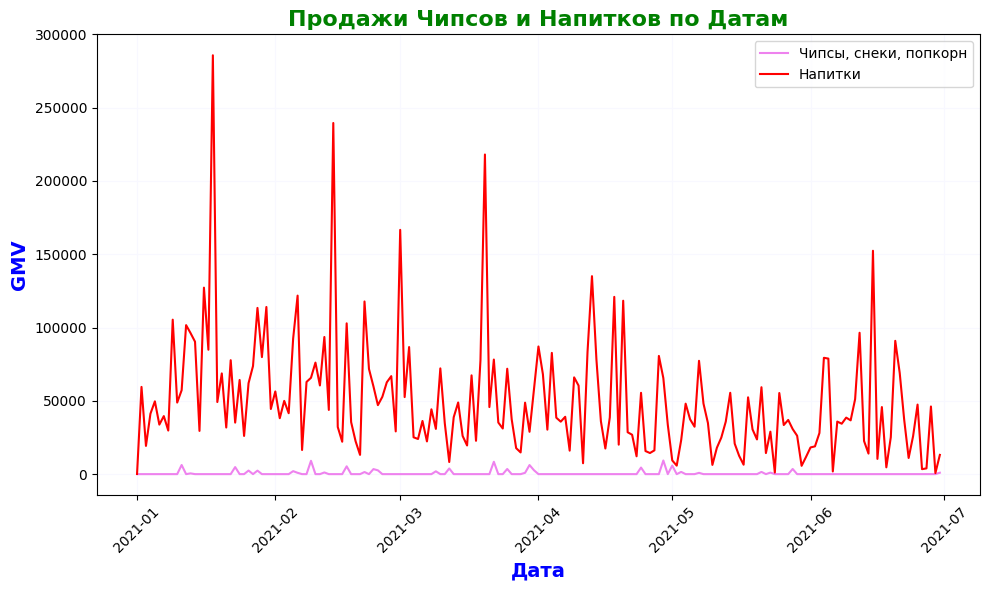

Коэффициент корреляции между продажами "Чипсы, снеки, попкорн" и напитками: 0.06


In [21]:
# Визуализация
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_data, x='Date', y='Snacks_Sales', label='Чипсы, снеки, попкорн', color='violet')
sns.lineplot(data=combined_data, x='Date', y='Drinks_Sales', label='Напитки', color='red')
plt.title('Продажи Чипсов и Напитков по Датам', fontsize=16, fontweight='bold', color='Green')
plt.xlabel('Дата', fontsize=14, fontweight='bold', color='Blue')
plt.ylabel('GMV', fontsize=14, fontweight='bold', color='Blue')
plt.xticks(rotation=45)
plt.legend()
plt.grid(color='ghostwhite')
plt.tight_layout()
plt.show()

# Вывод корреляции
print(f'Коэффициент корреляции между продажами "Чипсы, снеки, попкорн" и напитками: {correlation:.2f}')